# Project Overview
TODO

## Data
We are going to use the data from the following link:
https://www.kaggle.com/datasets/asaniczka/1-3m-linkedin-jobs-and-skills-2024
The dataset contains 1,348,454 job listings (rows), scraped from LinkedIn (publicly available listings on https://www.linkedin.com/jobs/) in January 2024.
The job listings were from 4 countries: the United States, the United Kingdom, Canada, and Australia, with following distributions:
- United States: 1,149,342 - 85%
- United Kingdom: 113,421 - 9%
- Canada: 55,972 - 4%
- Australia: 29,719 - 2%

The dataset provides the following files:
- linkedin_job_postings.csv: the job postings with data and metadata (such as company, job location, job title, search criteria, etc.) - 14 columns total (see below), sans summary and skills - ca. 420 MB
- job_skills.csv: the list of skills for each job link, skills are comma-seperated within one column - ca. 670 MB
- job_summary.csv: the summary of each job link - ca. 5.1 GB

While the job_skills and job_summary files each only contain one relevant column each (next to the link, which acts as the key), the job_postings file is more complex and contains the following columns:
- job_link: the link to the job posting - acts as the primary key in the overall dataset - string
- last_processed_time: the time the job posting was last processed during data collection - datetime
- got_summary: whether the job posting has a summary that was successfully extracted during data collection - boolean
- got_ner: indicates whether Named Entity Recognition (NER) was performed on the job posting or not - boolean
- is_being_worked: whether the job posting is currently being worked on - boolean
- job_title: the title of the job listing - string
- company: the company who created the job listing - string
- job_location: the location of the job (city, state, country (only if not US)) - string
- first_seen: the time the job posting was first seen on LinkedIn - datetime
- search_city: city used as a search criterion for collecting the job posting - string
- search_country: country used as a search criterion for collecting the job postings - string
- search_position: position used as a search criterion for collecting the job postings - string
- job_level: the job level of the job - there seem to be only two of these (see below) - string
- job_type: the type of the job (Onsite, Hybrid, Remote, etc. - see below) - string


In [1]:
import numpy as np  # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

In [2]:
# Load the data
job_postings = pd.read_csv('E:/Programming/cu-boulder/machine-learning/Course 1/project/data/linkedin_job_postings.csv')
job_summaries = pd.read_csv('E:/Programming/cu-boulder/machine-learning/Course 1/project/data/job_summary.csv')
job_skills = pd.read_csv('E:/Programming/cu-boulder/machine-learning/Course 1/project/data/job_skills.csv')

In [3]:
# Display the first few rows of the datasets
print("Number of rows for postings: ", job_postings.shape[0])
print(job_postings.head())
print("\n\n\n")
print("Number of rows for summaries: ", job_summaries.shape[0])
print(job_summaries.head())
print("\n\n\n")
print("Number of rows for skills: ", job_skills.shape[0])
print(job_skills.head())

Number of rows for postings:  1348454
                                            job_link  \
0  https://www.linkedin.com/jobs/view/account-exe...   
1  https://www.linkedin.com/jobs/view/registered-...   
2  https://www.linkedin.com/jobs/view/restaurant-...   
3  https://www.linkedin.com/jobs/view/independent...   
4  https://www.linkedin.com/jobs/view/group-unit-...   

             last_processed_time got_summary got_ner is_being_worked  \
0   2024-01-21 07:12:29.00256+00           t       t               f   
1   2024-01-21 07:39:58.88137+00           t       t               f   
2  2024-01-21 07:40:00.251126+00           t       t               f   
3  2024-01-21 07:40:00.308133+00           t       t               f   
4  2024-01-19 09:45:09.215838+00           f       f               f   

                                           job_title  \
0  Account Executive - Dispensing (NorCal/Norther...   
1                 Registered Nurse - RN Care Manager   
2               RESTAURA

We don't have skills but that's fine, we'll just ignore those listings when analysing skills/summaries

## Data Exploration & Cleaning
Let's start by exploring the data and checking for missing values.

In [4]:
print("Job Skills Invalid Values")
print(job_skills.isna().sum())
print("")
print("Job Summaries Invalid Values")
print(job_summaries.isna().sum())
print("")
print("Job Postings Invalid Values")
print(job_postings.isna().sum())

Job Skills Invalid Values
job_link         0
job_skills    2085
dtype: int64

Job Summaries Invalid Values
job_link       0
job_summary    0
dtype: int64

Job Postings Invalid Values
job_link                0
last_processed_time     0
got_summary             0
got_ner                 0
is_being_worked         0
job_title               0
company                11
job_location           19
first_seen              0
search_city             0
search_country          0
search_position         0
job_level               0
job_type                0
dtype: int64


As we can see, most of our data looks quite good.
We will drop the rows with missing values in the job_skills dataset, because they are unuseable for us when they do not include the skills.
We can work with the (very few) missing company and job_location values in the job_postings dataset though, so we'll keep those rows.

In [5]:
# Drop the job_skills rows with missing values
job_skills = job_skills.dropna()

Let's have a look at the different job titles and search positions in the job_postings dataset.

In [6]:
unique_titles = job_postings['job_title'].str.lower().unique()
print("Unique Job Titles: ", len(unique_titles))
print("Unique Job Titles (lower case): ", len(unique_titles))
print(job_postings['job_title'].str.lower().value_counts())
print("\n")

unique_positions = job_postings['search_position'].unique()
print("Unique Search Positions: ", len(unique_positions))
print(job_postings['search_position'].value_counts())

Unique Job Titles:  579066
Unique Job Titles (lower case):  579066
job_title
customer service representative                                                                                                            9436
lead sales associate-ft                                                                                                                    7325
shift manager                                                                                                                              5849
store manager                                                                                                                              5748
assistant manager                                                                                                                          5540
                                                                                                                                           ... 
clinical rn sharp memorial 1w oncology ft night; currently 

As we can see, we have many more unique job titles than search positions (584544 Job Titles vs. 1993 Search Positions).
If we convert the job titles to lower case, we drop by about 5000 to 579066 unique job titles. This also changes the job titles that occur most often (apparently, "Customer Service Representative" was written in different ways and accounted for 4000 more listings when converted to lower case).
Lowercasing search positions does not lead to a change.

It now seems like the "search position" would be a better job indicator than the job title, because the title frequently includes additional info, such as the location ("Survey Crew Chief - Michigan"), the field ("Quality Engineer - Aerospace"), the job level ("Designer 1") or general info ("Employment Attorney with relevant experience"); unfortunately, search position and job title frequently seem to be unrelated, as the examples below show.

In [7]:
print(job_postings.loc[56]['job_title'], " - ", job_postings.loc[56]['search_position'])
print(job_postings.loc[58]['job_title'], " - ", job_postings.loc[58]['search_position'])
print(job_postings.loc[64]['job_title'], " - ", job_postings.loc[64]['search_position'])
print(job_postings.loc[91]['job_title'], " - ", job_postings.loc[91]['search_position'])
print(job_postings.loc[124]['job_title'], " - ", job_postings.loc[124]['search_position'])
print(job_postings.loc[164]['job_title'], " - ", job_postings.loc[164]['search_position'])
print(job_postings.loc[177]['job_title'], " - ", job_postings.loc[177]['search_position'])

Designer I  -  Tattoo Artist
Regional Sales Manager, Mid-Atlantic  -  Director Of Religious Activities
Surgical Sales Representative  -  Handle Maker
Keyholder  -  Reader
Lead Software Engineer, Back End  -  Job Development Specialist
RN - Registered Nurse - 24060503EXPPLAT  -  Driver
Android Engineer  -  Tool Grinder Ii


## Let's take a look at the top 10 job titles, search positions, locations, and companies:

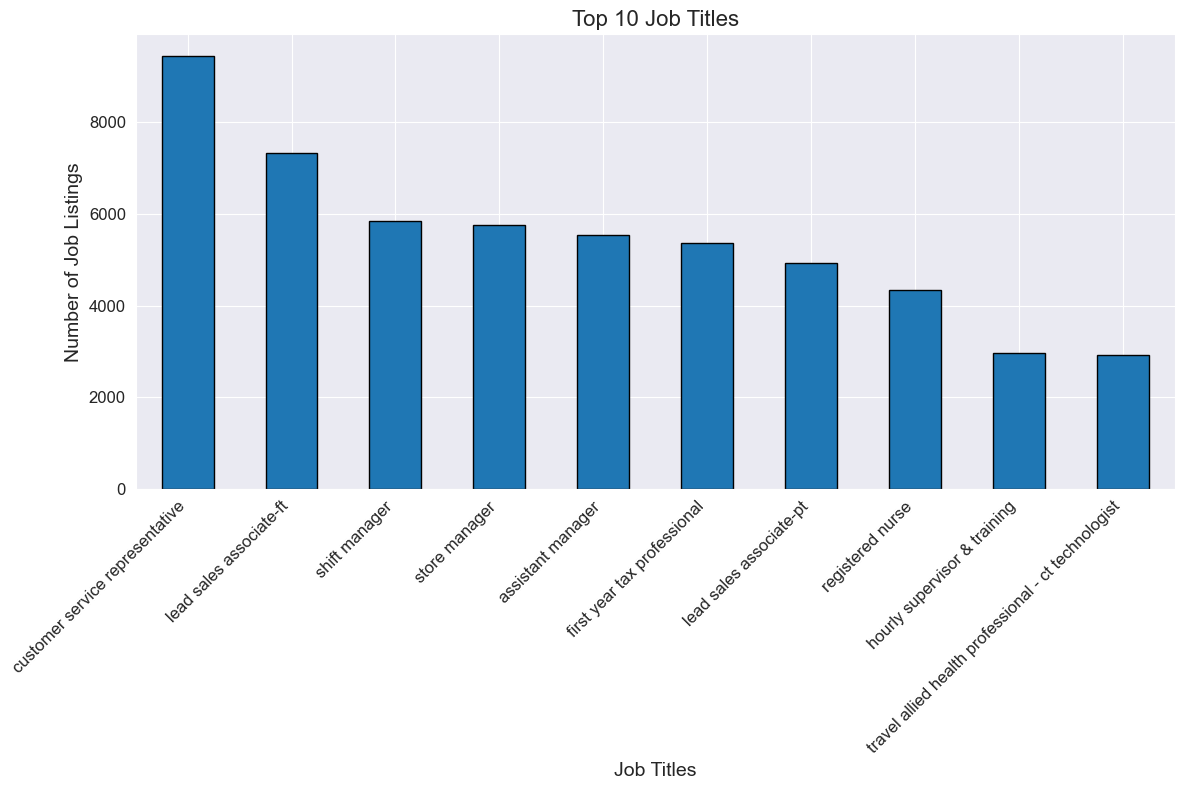

In [8]:
plt.figure(figsize=(12, 8))

top_job_titles = job_postings['job_title'].str.lower().value_counts().head(10)
top_job_titles.plot(kind='bar', edgecolor='black')

plt.title('Top 10 Job Titles', fontsize=16)
plt.xlabel('Job Titles', fontsize=14)
plt.ylabel('Number of Job Listings', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

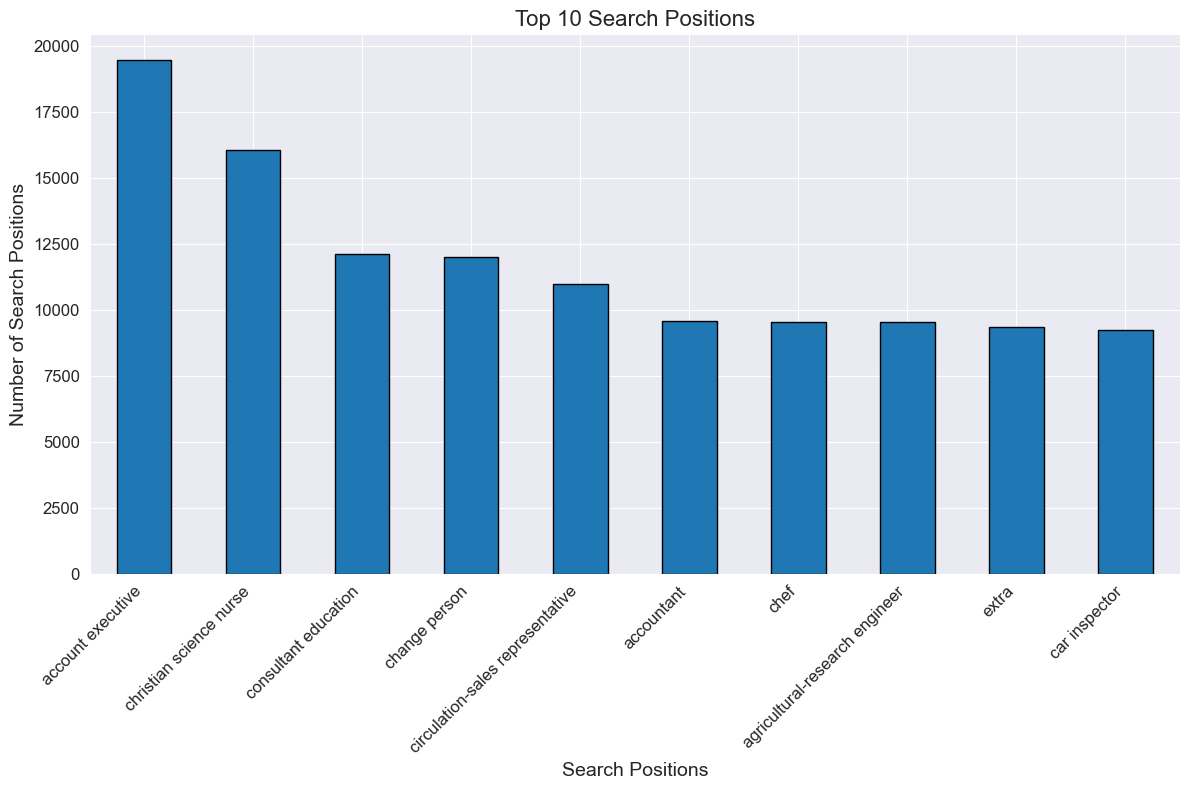

In [9]:
plt.figure(figsize=(12, 8))

top_job_titles = job_postings['search_position'].str.lower().value_counts().head(10)
top_job_titles.plot(kind='bar', edgecolor='black')

plt.title('Top 10 Search Positions', fontsize=16)
plt.xlabel('Search Positions', fontsize=14)
plt.ylabel('Number of Search Positions', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

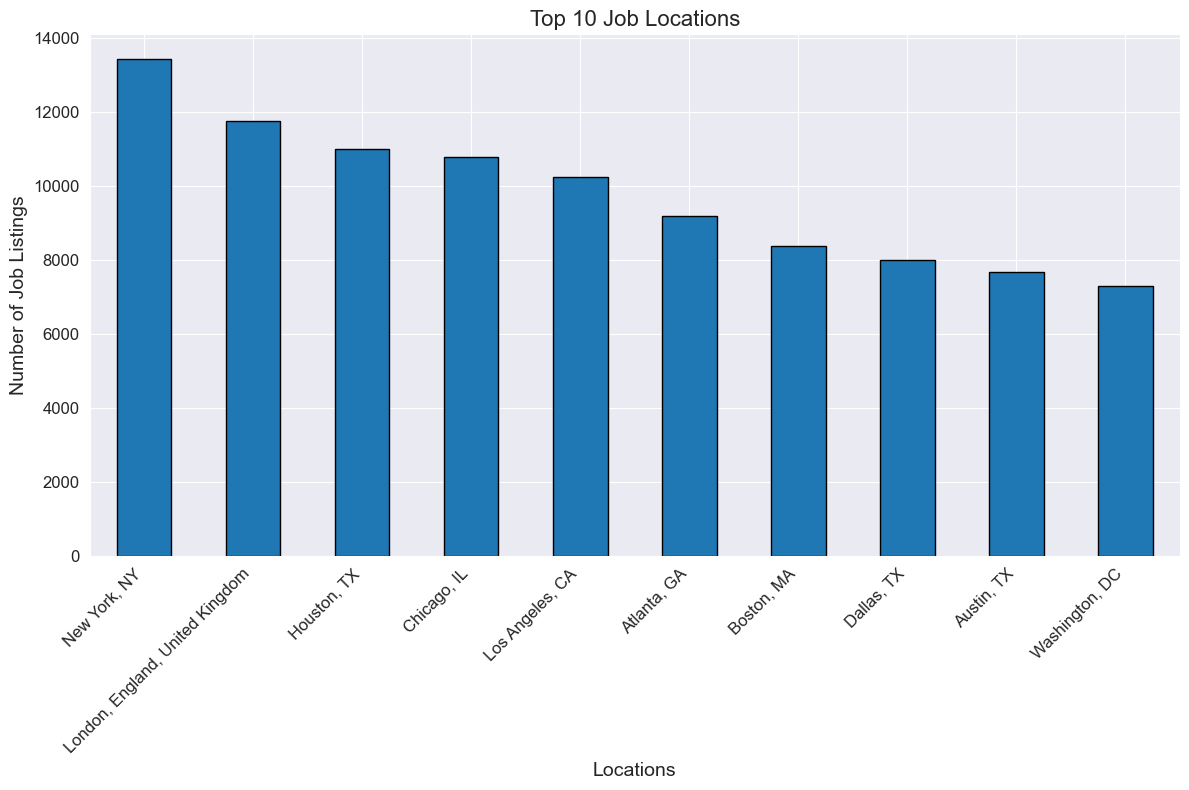

In [10]:
plt.figure(figsize=(12, 8))

top_locations = job_postings['job_location'].value_counts().head(10)
top_locations.plot(kind='bar', edgecolor='black')

plt.title('Top 10 Job Locations', fontsize=16)
plt.xlabel('Locations', fontsize=14)
plt.ylabel('Number of Job Listings', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

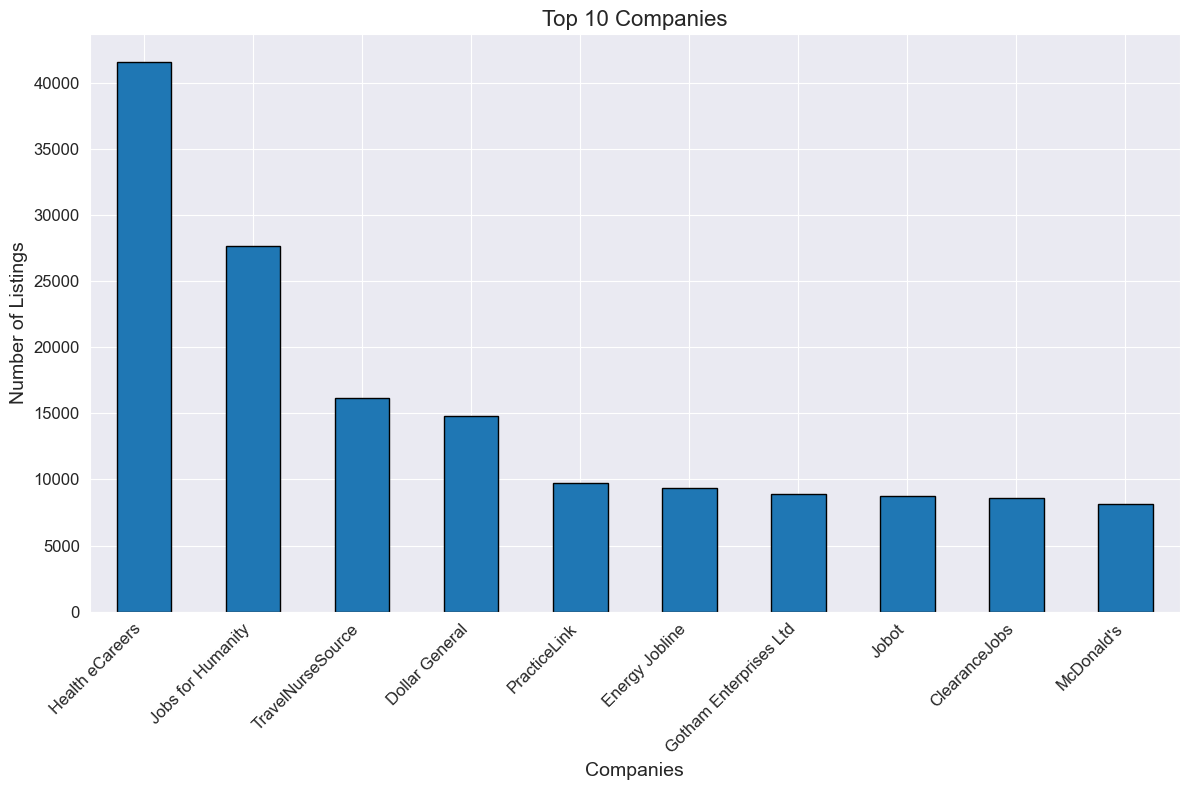

In [11]:
plt.figure(figsize=(12, 8))

top_locations = job_postings['company'].value_counts().head(10)
top_locations.plot(kind='bar', edgecolor='black')

plt.title('Top 10 Companies', fontsize=16)
plt.xlabel('Companies', fontsize=14)
plt.ylabel('Number of Listings', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Job Level Distribution
Let's see how the job levels are distributed.

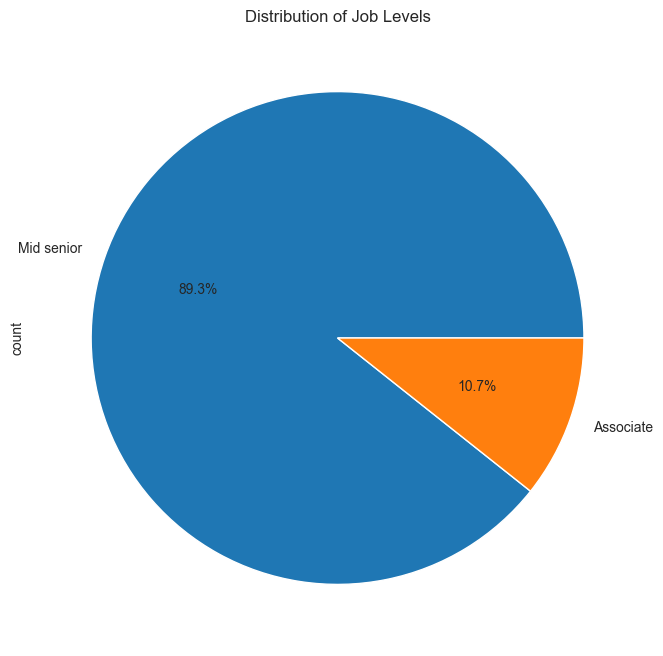

In [12]:
job_level_distribution = job_postings['job_level'].value_counts()
job_level_distribution.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8))
plt.title('Distribution of Job Levels')
plt.show()

Only "Mid senior" and "Associate" - that doesn't tell us much, so we might as well ignore/drop this column.

## How about "Job Types"?

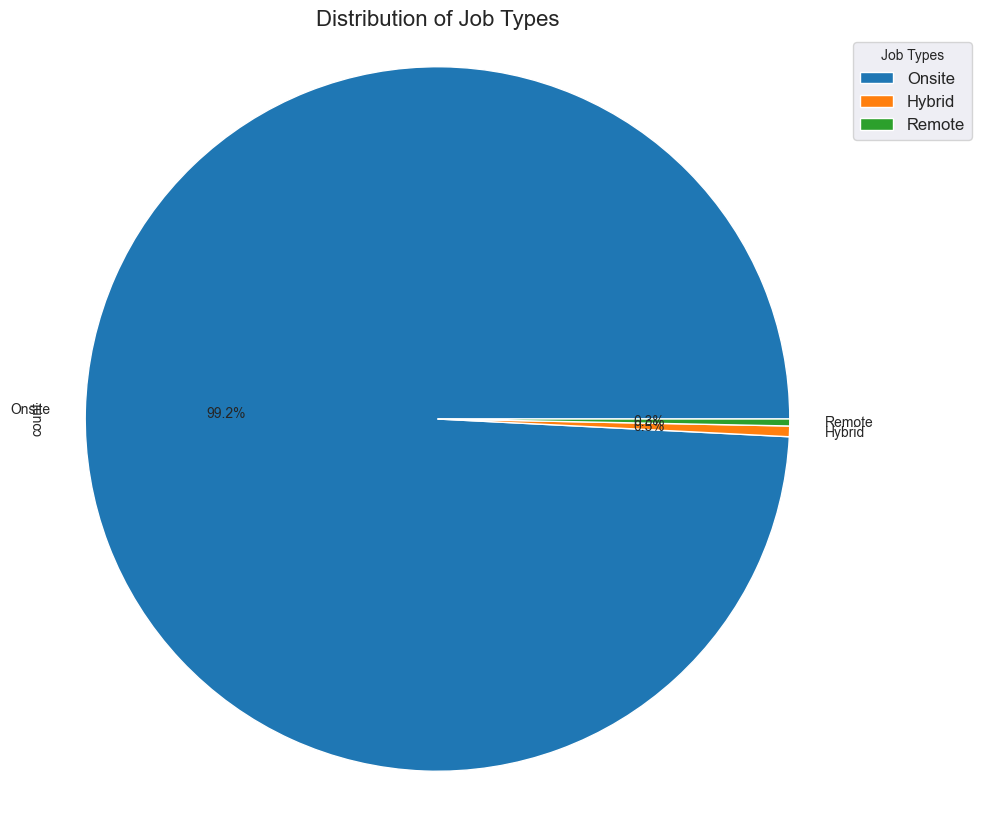

In [13]:
plt.figure(figsize=(10, 10))

job_type_distribution = job_postings['job_type'].value_counts()
job_type_distribution.plot(kind='pie', autopct='%1.1f%%')

plt.title('Distribution of Job Types', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(job_type_distribution.index, title='Job Types', loc='upper right', bbox_to_anchor=(1.2, 1), fontsize=12)
plt.show()

Definitely more interesting; we'll keep this in case we want to do some analysis of remote/hybrid/onsite jobs for specific positions, etc.

In [14]:
job_postings.head()

job_link  \
0  https://www.linkedin.com/jobs/view/account-exe...   
1  https://www.linkedin.com/jobs/view/registered-...   
2  https://www.linkedin.com/jobs/view/restaurant-...   
3  https://www.linkedin.com/jobs/view/independent...   
4  https://www.linkedin.com/jobs/view/group-unit-...   

             last_processed_time got_summary got_ner is_being_worked  \
0   2024-01-21 07:12:29.00256+00           t       t               f   
1   2024-01-21 07:39:58.88137+00           t       t               f   
2  2024-01-21 07:40:00.251126+00           t       t               f   
3  2024-01-21 07:40:00.308133+00           t       t               f   
4  2024-01-19 09:45:09.215838+00           f       f               f   

                                           job_title  \
0  Account Executive - Dispensing (NorCal/Norther...   
1                 Registered Nurse - RN Care Manager   
2               RESTAURANT SUPERVISOR - THE FORKLIFT   
3                      Independent Real Estate Agent   
4  Group/Unit Supervisor (Systems Support Manager...   

                        company          job_location  first_seen  \
0                            BD         San Diego, CA  2024-01-15   
1             Trinity Health MI     Norton Shores, MI  2024-01-14   
2       Wasatch Adaptive Sports             Sandy, UT  2024-01-14   
3    Howard Hanna | Rand Realty  Englewood Cliffs, NJ  2024-01-16   
4  IRS, Office of Chief Counsel          Chamblee, GA  2024-01-17   

   search_city search_country                       search_position  \
0     Coronado  United States                           Color Maker   
1  Grand Haven  United States              Director Nursing Service   
2       Tooele  United States                              Stand-In   
3    Pinehurst  United States                     Real-Estate Clerk   
4      Gadsden  United States  Supervisor Travel-Information Center   

    job_level job_type  
0  Mid senior   Onsite  
1  Mid senior   Onsite  
2  Mid senior   Onsite  
3  Mid senior   Onsite  
4  Mid senior   Onsite

# Data Preprocessing
Now let's drop some columns that we won't need for our analysis: last_processed_time, got_summary, got_ner, is_being_worked, first_seen and job_level.

In [15]:
job_postings = job_postings.drop(
    columns=['last_processed_time', 'got_summary', 'got_ner', 'is_being_worked', 'first_seen', 'job_level'])

In [16]:
job_postings.head()

job_link  \
0  https://www.linkedin.com/jobs/view/account-exe...   
1  https://www.linkedin.com/jobs/view/registered-...   
2  https://www.linkedin.com/jobs/view/restaurant-...   
3  https://www.linkedin.com/jobs/view/independent...   
4  https://www.linkedin.com/jobs/view/group-unit-...   

                                           job_title  \
0  Account Executive - Dispensing (NorCal/Norther...   
1                 Registered Nurse - RN Care Manager   
2               RESTAURANT SUPERVISOR - THE FORKLIFT   
3                      Independent Real Estate Agent   
4  Group/Unit Supervisor (Systems Support Manager...   

                        company          job_location  search_city  \
0                            BD         San Diego, CA     Coronado   
1             Trinity Health MI     Norton Shores, MI  Grand Haven   
2       Wasatch Adaptive Sports             Sandy, UT       Tooele   
3    Howard Hanna | Rand Realty  Englewood Cliffs, NJ    Pinehurst   
4  IRS, Office of Chief Counsel          Chamblee, GA      Gadsden   

  search_country                       search_position job_type  
0  United States                           Color Maker   Onsite  
1  United States              Director Nursing Service   Onsite  
2  United States                              Stand-In   Onsite  
3  United States                     Real-Estate Clerk   Onsite  
4  United States  Supervisor Travel-Information Center   Onsite

In [17]:
# todo remove /n from job_summary

In [181]:
data = pd.merge(job_postings, job_summaries, on='job_link')
data = pd.merge(data, job_skills, on='job_link')
data.head()

job_link  \
0  https://www.linkedin.com/jobs/view/account-exe...   
1  https://www.linkedin.com/jobs/view/registered-...   
2  https://www.linkedin.com/jobs/view/restaurant-...   
3  https://www.linkedin.com/jobs/view/independent...   
4  https://www.linkedin.com/jobs/view/registered-...   

                                           job_title  \
0  Account Executive - Dispensing (NorCal/Norther...   
1                 Registered Nurse - RN Care Manager   
2               RESTAURANT SUPERVISOR - THE FORKLIFT   
3                      Independent Real Estate Agent   
4                              Registered Nurse (RN)   

                      company          job_location  search_city  \
0                          BD         San Diego, CA     Coronado   
1           Trinity Health MI     Norton Shores, MI  Grand Haven   
2     Wasatch Adaptive Sports             Sandy, UT       Tooele   
3  Howard Hanna | Rand Realty  Englewood Cliffs, NJ    Pinehurst   
4           Trinity Health MI          Muskegon, MI     Muskegon   

  search_country           search_position job_type  \
0  United States               Color Maker   Onsite   
1  United States  Director Nursing Service   Onsite   
2  United States                  Stand-In   Onsite   
3  United States         Real-Estate Clerk   Onsite   
4  United States        Nurse Practitioner   Onsite   

                                         job_summary  \
0  Responsibilities\nJob Description Summary\nJob...   
1  Employment Type:\nFull time\nShift:\nDescripti...   
2  Job Details\nDescription\nWhat You'll Do\nAs a...   
3  Who We Are\nRand Realty is a family-owned brok...   
4  Employment Type:\nFull time\nShift:\n12 Hour N...   

                                          job_skills  
0  Medical equipment sales, Key competitors, Term...  
1  Nursing, Bachelor of Science in Nursing, Maste...  
2  Restaurant Operations Management, Inventory Ma...  
3  Real Estate, Customer Service, Sales, Negotiat...  
4  Nursing, BSN, Medical License, Virtual RN, Nur...

In [182]:
# todo remove non-words from job_summary (and, to, for, the, a, of, 

## Data Analysis
Let's start by analysing the job summaries with a bag of words approach.

In [183]:
from keras.layers import TextVectorization

vectorise_layer_summaries = TextVectorization()
vectorise_layer_summaries.adapt(data.job_summary[0:500])
model = tf.keras.models.Sequential()

# Start by creating an explicit input layer. It needs to have a shape of
# (1,) (because we need to guarantee that there is exactly one string
# input per batch), and the dtype needs to be 'string'.
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorise_layer_summaries)




In [184]:
number_of_samples = 50

samples = data.job_summary[0:number_of_samples]

predictions = []
for i in range(0, number_of_samples):
    predictions.append(model.predict([data.job_summary[i]]))

print(predictions[0])

vectorised_summaries = []

# convert all "predictions" to vectorised form of the text
for i in range(0, number_of_samples):
    unique, counts = np.unique(predictions[i], return_counts=True)
    bla = dict(zip(unique, counts))
    array = np.zeros(vectorise_layer_summaries.vocabulary_size())
    for (index, value) in bla.items():
        array[index] = value

    vectorised_summaries.append(array)

df = pd.DataFrame(vectorised_summaries)




1/1 [==============================] - 0s 21ms/step
[[   79    33   155   525    33   155    17    16     4  2834     5   709
   3412    11    82     5     4   749   495    68   279   742     7     4
    446  2576     4   446     5 13166    11    14   797     2  1294   222
   1055 13578   103  1123     4  5138     2   627     5    23     5  9364
    202     2   247     3     4   412     2   540     5    14 15217     5
   7602   179   173  9043   981    30     4  5136     2   542  4228   187
     22  1882  3110   364  2483    17   521    22     4   506  3106   226
     14   495   237    11   136  1728    69     3  1602  5220   180    69
      2  1941    21    70     7   176   437    15  2219     3   272   389
      2   877    24   150  1630   877     6  5050     5   709     9    69
     33   766   730  1066  1956    29  1743  3021   728  3021  4999    50
    594     7     4  6129  5423   525     4   730  1066    11   129     8
    649    83     2    58     3    71     2   775    89   18

In [185]:
indices = range(0, 50)

summary_distances = np.zeros((number_of_samples, number_of_samples))

for i in indices:
    for j in indices:
        distance = np.linalg.norm(df.iloc[i] - df.iloc[j])
        summary_distances[i][j] = distance

print(summary_distances)


[[  0.          47.44470466  45.19955752 ...  62.36184731 189.21944932
   61.44102864]
 [ 47.44470466   0.          54.09251335 ...  71.76350047 204.15925157
   45.51922671]
 [ 45.19955752  54.09251335   0.         ...  65.74191966 194.16230324
   63.40346994]
 ...
 [ 62.36184731  71.76350047  65.74191966 ...   0.         184.08421986
   82.2678552 ]
 [189.21944932 204.15925157 194.16230324 ... 184.08421986   0.
  226.95153668]
 [ 61.44102864  45.51922671  63.40346994 ...  82.2678552  226.95153668
    0.        ]]


<Axes: >

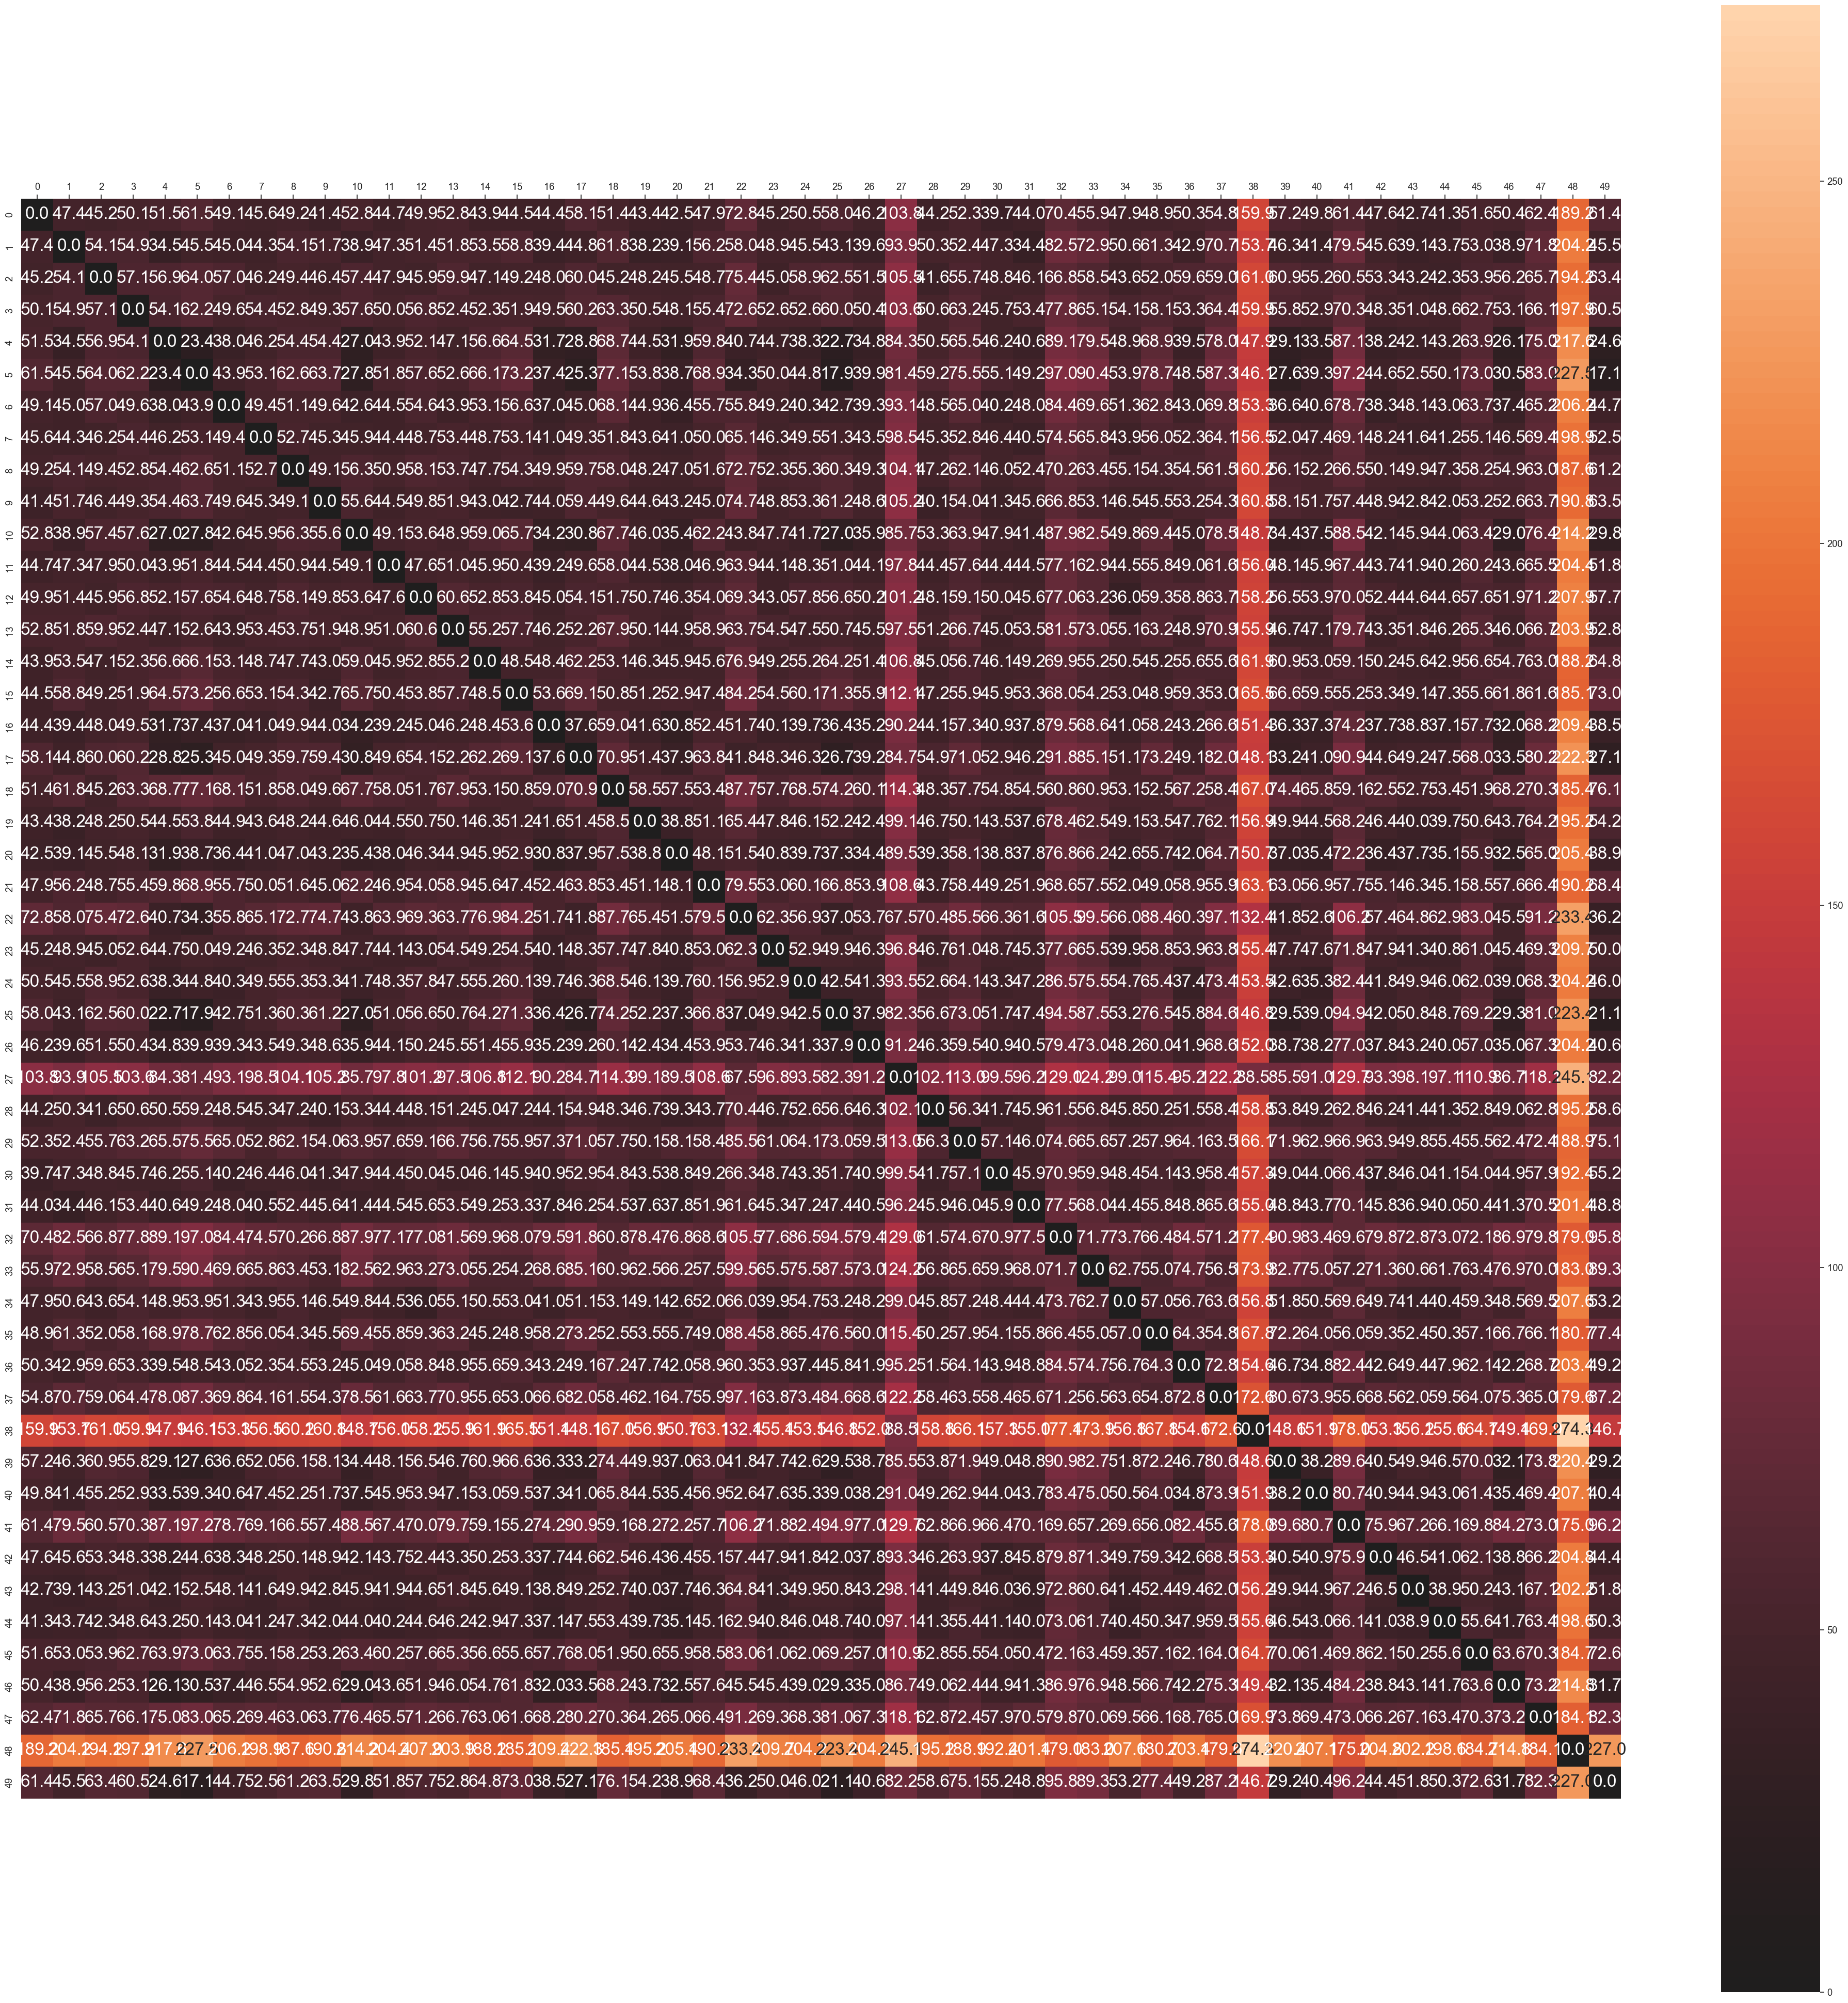

In [186]:
fig, ax = plt.subplots(figsize=(50, 50))
ax.xaxis.tick_top()
sns.set(font_scale=1.2)
sns.heatmap(summary_distances, annot=True, square=True, ax=ax, fmt=".1f", center=0.0, annot_kws={"size": 24})

In [194]:
# Test cell for easy experimentation
i = 49
j = 17
print(data.job_title[i], " vs. ", data.job_title[j])

print(summary_distances[i][j])

Employment Attorney with relevant experience  vs.  Analyst, Associate Plan Configuration & Quality Control
27.055498516937366


In [191]:
print(data.job_summary[i])
print("__________________________________________________________________________________")
print(data.job_summary[j])
print("__________________________________________________________________________________")
print(data.iloc[i])
print(data.iloc[j])

Requisition Number:
108199 - 32
Description:
At KPMG, you can become an integral part of a dynamic team at one of the world's top tax firms. Enjoy a collaborative, future-forward culture that empowers your success. Work with KPMG's extensive network of specialists & enjoy access to our Ignition Centers, where deep industry knowledge merges with cutting-edge technologies to create innovative tax solutions. Join a diverse team helping high-profile clients understand, analyze, and respond to complex business opportunities and challenges. Develop your career through a range of multifaceted engagements, formal training, and informal mentoring. At KPMG, we believe nothing is more important than investing in our culture because it's an investment in our people, our future, and what we stand for as a firm
KPMG is currently seeking a Senior Associate to join our Business Tax Services practice.
Responsibilities:
Prioritize work to meet milestones and complete deliverables in a timely manner whil

In [ ]:
# todo let's also correlate the job skills, to reecive a total score of correlation between two job postings